In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skvideo.io
import skvideo.datasets
import os
from copy import deepcopy as copy

## Generating Pixels to embed in
This is the 3d Chaotic map used in Hossain et. al

In [2]:
class chaotic_pixels:
    def __init__(self):
        self.x_1 = 0.2350
        self.y_1 = 0.3500
        self.z_1 = 0.7350
        self.v_1 = (self.x_1, self.y_1, self.z_1)
        
        self.alpha = 0.0125 # 0 < alpha < 0.015
        self.beta = 0.0157  # 0 < beta < 0.022
        self.gamma = 3.7700 # 3.53 < gamma < 3.81
        
        self.N = 10**15
    
    def logistic_chaos_map(self, point):
        xn, yn, zn = point
        x = (self.gamma*xn*(1-xn)) + (self.beta*(yn**2)*xn) + (self.alpha*(zn**3))
        y = (self.gamma*yn*(1-yn)) + (self.beta*(zn**2)*yn) + (self.alpha*(xn**3))    
        z = (self.gamma*zn*(1-zn)) + (self.beta*(xn**2)*zn) + (self.alpha*(yn**3))
    
        return x, y, z
    
    def normalize(self, point, video_dims):
        x, y, z = point
        return (np.int64(x*self.N)%video_dims[0], np.int64(y*self.N)%video_dims[1], np.int64(z*self.N)%video_dims[2])
    
    def get_pixels(self, video_dims, data_len, get_reps=False):
        prev = self.v_1
        values = []
        hash_table = {}
        count = 0
        reps = []
        i = 0
        while i < data_len:
            next_point = self.logistic_chaos_map(prev)
            n_next = self.normalize(next_point, video_dims)
            prev = next_point
            
            key = hash(n_next)
            if key in hash_table:
                if n_next in hash_table[key]:
                    reps.append(i)
#                     if(len(reps)%100 == 0):
#                         print(reps[-1])
                    continue
                else:
                    hash_table[key].append(n_next)
            else:
                hash_table[key] = [n_next]
        
            values.append(n_next)
            i+=1
            
        values = np.array(values, dtype=np.int64)
#         ids = np.arange(0, data_len)
#         print(ids.shape, values.shape)
#         values = np.c_[values, ids]
#         values = values[values[:,0].argsort()]
        
        if get_reps:
            return values, reps
        return values

## Reading the video

In [3]:
video = skvideo.io.vread("test-720p_1.mp4")

In [4]:
video.shape

(132, 720, 1280, 3)

In [5]:
video[0][0][0]

array([104, 112,  46], dtype=uint8)

In [6]:
MAX_DATA_LEN = np.prod(video.shape)
MAX_DATA_LEN # in bytes

364953600

In [7]:
MAX_DATA_LEN/1024/1024

348.046875


We can encode about 348MB of data in this small video

In [8]:
video_dims = video.shape[0:3]

In [9]:
video_dims

(132, 720, 1280)

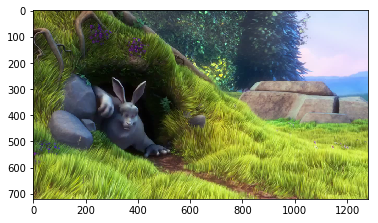

In [10]:
plt.imshow(video[0])

## Getting pixel values for some sample data

In [11]:
b_data = os.urandom(1024)

In [12]:
max(b_data)

255

In [13]:
data_len = len(b_data)
data_len

1024

In [14]:
generator = chaotic_pixels()

In [15]:
pixels_to_encode = generator.get_pixels(video_dims, data_len)

In [16]:
pixels_to_encode.shape

(1024, 3)

`pixels_to_encode` has the locations of the pixels in the video where we wish to encode our information. 

In [17]:
pixels_to_encode.min(axis = 0), pixels_to_encode.max(axis = 0)

(array([0, 0, 0]), array([ 131,  719, 1279]))

This shows that every pixel location is unique

## LSB Substitution

We're going to be employing the 3-3-2 LSB substitution. 3 lsb of red, 3 in green and 2 in blue.

In [18]:
format(118, '08b')

'01110110'

In [19]:
def lsb_sub_332(pixel, value):
    bits = format(value, '08b')
    
#     print(bits)
#     for i in pixel:
#         print(format(i, '08b'))
    
    pixel[0] &= 248
    pixel[1] &= 248
    pixel[2] &= 252
    
    for i in range(0, 3):
        pixel[0] = pixel[0] | (int(bits[i]) << (2-i))
    
    for i in range(3, 6):
        pixel[1] = pixel[1] | (int(bits[i]) << (5-i))
    
    for i in range(6, 8):
        pixel[2] = pixel[2] | (int(bits[i]) << (7-i))
    
#     for i in pixel:
#         print(format(i, '08b'))
    
    return pixel

In [20]:
lsb_sub_332([123, 210, 215], 118)

[123, 213, 214]

## Encoding the data into the frames

In [21]:
encoded_video = copy(video)

In [22]:
x, y, z = pixels_to_encode[0]

In [23]:
video[int(x)][int(y)][int(z)]

array([ 62,  73, 100], dtype=uint8)

In [24]:
for i in range(0, data_len):
    x, y, z = pixels_to_encode[i]
    x, y, z = int(x), int(y), int(z)
    encoded_video[x][y][z] = lsb_sub_332(encoded_video[x][y][z], b_data[i])

In [25]:
x, y, z = pixels_to_encode[0]
x, y, z = int(x), int(y), int(z)

In [26]:
video[x][y][z], encoded_video[x][y][z], b_data[0]

(array([ 62,  73, 100], dtype=uint8), array([ 58,  73, 100], dtype=uint8), 68)

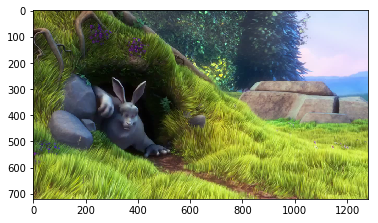

In [27]:
plt.imshow(video[0])

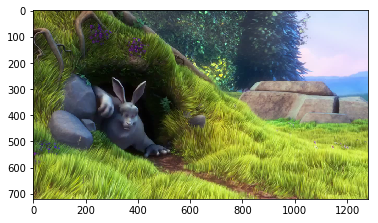

In [28]:
plt.imshow(encoded_video[0])

## Analysis

In [29]:
import skvideo.measure
from skvideo.measure import strred, mse, psnr, msssim
from skvideo.utils import vshape
from cycler import cycler

### Calculating Mean Squared Error

In [30]:
r_mse = mse(vshape(video[:,:,:,0]), vshape(encoded_video[:,:,:,0]))
g_mse = mse(vshape(video[:,:,:,1]), vshape(encoded_video[:,:,:,1]))
b_mse = mse(vshape(video[:,:,:,2]), vshape(encoded_video[:,:,:,2]))

Text(0.5, 1.0, 'Mean Squared Error of every Frame')

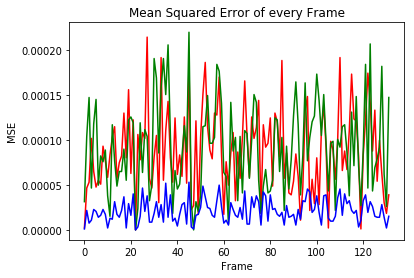

In [31]:
default_cycler = cycler('color', ['r', 'g', 'b'])
fig, ax = plt.subplots()
ax.set_prop_cycle(default_cycler)
ax.plot(r_mse)
ax.plot(g_mse)
ax.plot(b_mse)
ax.set_ylabel("MSE")
ax.set_xlabel("Frame")
ax.set_title("Mean Squared Error of every Frame")

In [32]:
mse_max   = np.max(r_mse), np.max(g_mse), np.max(b_mse)
mse_min   = np.min(r_mse), np.min(g_mse), np.min(b_mse)
mse_mean  = np.mean(r_mse), np.mean(g_mse), np.mean(b_mse)

In [33]:
df = pd.DataFrame([mse_max, mse_min, mse_mean], columns=["R", "G", "B"], index=["Max", "Min", "Mean"])
df = df.transpose()
df 

,Max,Min,Mean
R,0.000215,0.0,0.000088
G,0.000220,0.0,0.000092
B,0.000053,0.0,0.000021


### Calculating PSNR

In [34]:
r_psnr = psnr(vshape(video[:,:,:,0]), vshape(encoded_video[:,:,:,0]))
g_psnr = psnr(vshape(video[:,:,:,1]), vshape(encoded_video[:,:,:,1]))
b_psnr = psnr(vshape(video[:,:,:,2]), vshape(encoded_video[:,:,:,2]))

/home/gurupunskill/anaconda3/lib/python3.6/site-packages/skvideo/measure/psnr.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10 * np.log10(maxsq / mse)


Text(0.5, 1.0, 'PSNR of every Frame')

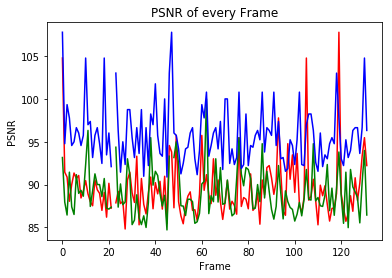

In [35]:
default_cycler = cycler('color', ['r', 'g', 'b'])
fig, ax = plt.subplots(nrows = 1)
ax.set_prop_cycle(default_cycler)
ax.plot(r_psnr)
ax.plot(g_psnr)
ax.plot(b_psnr)
ax.set_ylabel("PSNR")
ax.set_xlabel("Frame")
ax.set_title("PSNR of every Frame")

In [36]:
psnr_max   = np.max(r_psnr), np.max(g_psnr), np.max(b_psnr)
psnr_min   = np.min(r_psnr), np.min(g_psnr), np.min(b_psnr)
psnr_mean  = np.mean(r_psnr), np.mean(g_psnr), np.mean(b_psnr)

In [37]:
df = pd.DataFrame([psnr_max, psnr_min, psnr_mean], columns=["R", "G", "B"], index=["Max", "Min", "Mean"])
df = df.transpose()
df 

,Max,Min,Mean
R,inf,84.809576,inf
G,inf,84.701268,inf
B,inf,90.874267,inf


### Getting data distribution per frame

In [38]:
pixels_to_encode.shape

(1024, 3)

In [39]:
sorted_pixels = np.sort(pixels_to_encode, axis = 0)
sorted_pixels

array([[   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    1],
       ...,
       [ 131,  718, 1274],
       [ 131,  719, 1278],
       [ 131,  719, 1279]])

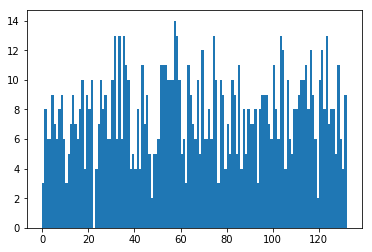

In [40]:
ppf = plt.hist(sorted_pixels[:, 0], bins=np.arange(0, 133, 1))

In [41]:
ppf = ppf[0]

In [42]:
ppf.max(), ppf.argmax()

(14.0, 57)

In [43]:
ppf.min(), ppf.argmin()

(0.0, 22)

In [44]:
ppf.mean()

7.757575757575758

In [45]:
skvideo.io.vwrite("output-test-720_1.mp4", encoded_video)